<h1 style="text-align:center;">Лабораторная работа №5.1</h2>

<h2 style="text-align:center;">Решение  уравнения переноса</h2>

<h3 style="text-align:center;">Тулупов Николай Дмитриевич</h3>
<h3 style="text-align:center;">Б01-204</h3>

### **Введение**

**Цель:**

- предъявить численное решение уравнения переноса и сравнить его с аналитически 
- использовать схемы для численного решения: уголок, прямоугольник, Лакс-Вендрофф (Явная четырехточечная схема)
- провести исследование на сходимость (сравнение численного и аналитического решения) 
- провести анализ порядка аппроксимации (сходимости) (график с убыванием нормы ошибки в зависимости от шага интегрирования в логарифмическом масштабе)

In [134]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import linregress

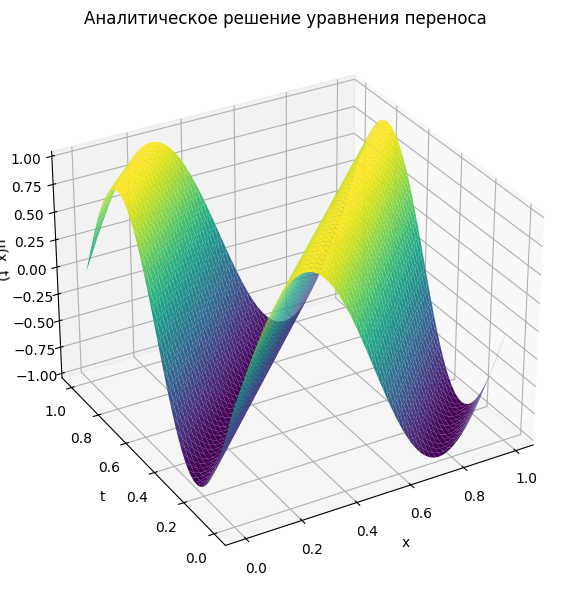

In [135]:
# Параметры
a = 1.0         # скорость переноса

X = 1.0         # длина отрезка по x
T = 1.0         # конечное время

Nx = 200        # число точек по пространству
Nt = 200        # число точек по времени


# Сетка
x = np.linspace(0, X, Nx, endpoint=False)
t = np.linspace(0, T, Nt)
X_grid, T_grid = np.meshgrid(x, t, indexing='xy')


# Аналитическое решение: u(x,t) = sin(2π(x-at))
U = np.sin(2 * np.pi * (X_grid - a * T_grid))  # автоматическая периодичность


# Построение 3D-графика
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_grid, T_grid, U, cmap='viridis')

ax.view_init(elev=30, azim=-120)#поворот камеры

ax.set_title("Аналитическое решение уравнения переноса")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u(x, t)")

plt.tight_layout()
plt.show()


 **Численные схемы для решения уравнения переноса**

Рассматривается уравнение переноса:

$$
\frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x} = 0, \quad x \in [0, 1],\ t > 0,\ a > 0
$$

Аналитическое решение для начальных условий $u(x, 0) = \sin(2\pi x)$ при периодических границах:

$$
u(x, t) = \sin(2\pi(x - at))
$$

Рассматриваются три численные схемы:

---

**1. Схема «уголок» (односторонняя, явная, 1-го порядка)**

$$
u_i^{n+1} = u_i^n - \frac{a \Delta t}{\Delta x} \left( u_i^n - u_{i-1}^n \right)
$$

Порядок аппроксимации: $O(\Delta x) + O(\Delta t)$

---

**2. Схема «прямоугольник» (центральная разность, неустойчивая при a Δt / Δx > 1)**

$$
u_i^{n+1} = u_i^n - \frac{a \Delta t}{2 \Delta x} \left( u_{i+1}^n - u_{i-1}^n \right)
$$

Порядок аппроксимации: $O(\Delta x^2)$ по пространству, $O(\Delta t)$ по времени.  
Схема неустойчива при $C = \frac{a \Delta t}{\Delta x} > 1$.

---

**3. Схема Лакса–Вендроффа (явная четырёхточечная, 2-го порядка)**

$$
u_i^{n+1} = u_i^n - \frac{a \Delta t}{2 \Delta x} \left( u_{i+1}^n - u_{i-1}^n \right)
+ \frac{a^2 \Delta t^2}{2 \Delta x^2} \left( u_{i+1}^n - 2u_i^n + u_{i-1}^n \right)
$$

Порядок аппроксимации: $O(\Delta x^2) + O(\Delta t^2)$

---

Для всех схем используется равномерная сетка по пространству с шагом $\Delta x$ и временной шаг $\Delta t$.



In [136]:
# Параметры задачи
a = 1.0                  # скорость переноса
T = 1.0                  # конечное время
C = 0.9                  # число Куранта (для устойчивости C <= 1)
# C = насколько далеко информация успевает пройти за 1 шаг по времени по сравнению с пространственным шагом.

### **Схема «уголок»**

In [137]:
def solve_corner(N, T, a, C):
    # Сетка
    x = np.linspace(0, 1, N, endpoint=False)
    dx = x[1] - x[0]
    dt = C * dx / a
    Nt = int(T / dt)

    # Начальное условие
    u = np.sin(2 * np.pi * x)

    # Временное продвижение
    for n in range(Nt):
        u_new = np.copy(u)
        for i in range(N):
            u_new[i] = u[i] - (a * dt / dx) * (u[i] - u[i - 1])  # i-1 автоматически периодически
        u = u_new

    # Аналитическое решение
    x_shifted = (x - a * T) % 1.0
    u_exact = np.sin(2 * np.pi * x_shifted)

    # Ошибка
    error = np.sqrt(np.sum((u - u_exact) ** 2) * dx)

    return dx, error, x, u, u_exact

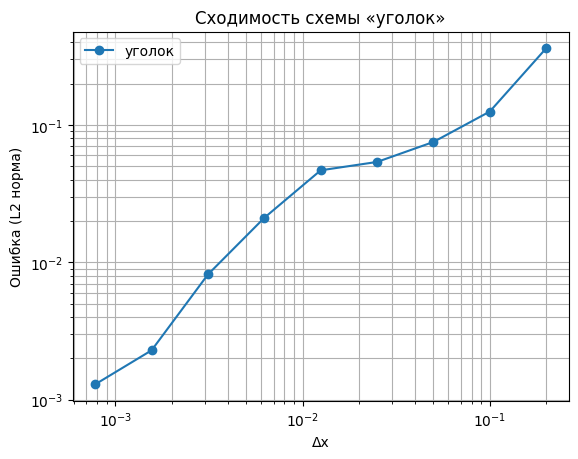

In [138]:
# Исследование сходимости
Ns = [5, 10, 20, 40, 80, 160, 320, 640, 1280]
errors = []
deltas = []

C = 0.9
for N in Ns:
    dx, error, *_ = solve_corner(N, T, a, C)
    errors.append(error)
    deltas.append(dx)

# График сходимости
plt.figure()
plt.loglog(deltas, errors, 'o-', label='уголок')
plt.xlabel('Δx')
plt.ylabel('Ошибка (L2 норма)')
plt.grid(True, which='both')
plt.legend()
plt.title('Сходимость схемы «уголок»')
plt.show()

In [139]:
logs_dx = np.log(deltas)
logs_err = np.log(errors)
slope, intercept, *_ = linregress(logs_dx, logs_err)

print(f"Порядок аппроксимации ≈ {slope:.3f}")

Порядок аппроксимации ≈ 0.960


### **Схема «прямоугольник»**

In [140]:
def solve_rectangle(N, T, a, C):
    # Сетка
    x = np.linspace(0, 1, N, endpoint=False)
    dx = x[1] - x[0]
    dt = C * dx / a
    Nt = int(T / dt)

    # Начальное условие
    u = np.sin(2 * np.pi * x)

    # Временное продвижение
    for n in range(Nt):
        u_new = np.copy(u)
        for i in range(N):
            u_new[i] = u[i] - (a * dt / (2 * dx)) * (u[(i + 1) % N] - u[i - 1])
        u = u_new

    # Аналитическое решение
    x_shifted = (x - a * T) % 1.0
    u_exact = np.sin(2 * np.pi * x_shifted)

    # Ошибка
    error = np.sqrt(np.sum((u - u_exact) ** 2) * dx)

    return dx, error, x, u, u_exact

C:\Users\pc\AppData\Local\Temp\ipykernel_18508\697933308.py:23: RuntimeWarning: overflow encountered in square
  error = np.sqrt(np.sum((u - u_exact) ** 2) * dx)


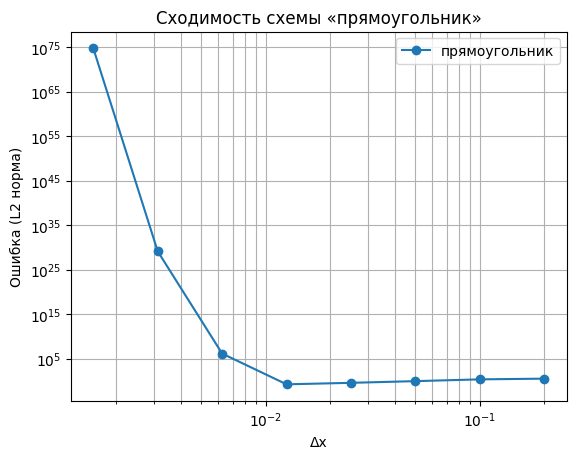

In [141]:
# Исследование сходимости
Ns = [5, 10, 20, 40, 80, 160, 320, 640, 1280]
errors = []
deltas = []

C = 0.9
for N in Ns:
    dx, error, *_ = solve_rectangle(N, T, a, C)
    errors.append(error)
    deltas.append(dx)

# График сходимости
plt.figure()
plt.loglog(deltas, errors, 'o-', label='прямоугольник')
plt.xlabel('Δx')
plt.ylabel('Ошибка (L2 норма)')
plt.grid(True, which='both')
plt.legend()
plt.title('Сходимость схемы «прямоугольник»')
plt.show()

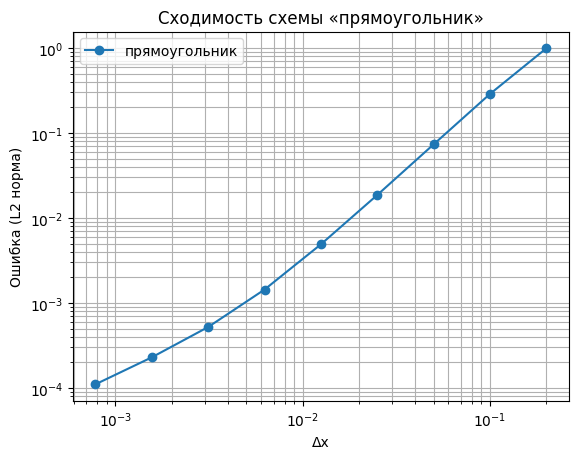

In [142]:
# Исследование сходимости
Ns = [5, 10, 20, 40, 80, 160, 320, 640, 1280]
errors = []
deltas = []

C = 0.01
for N in Ns:
    dx, error, *_ = solve_rectangle(N, T, a, C)
    errors.append(error)
    deltas.append(dx)

# График сходимости
plt.figure()
plt.loglog(deltas, errors, 'o-', label='прямоугольник')
plt.xlabel('Δx')
plt.ylabel('Ошибка (L2 норма)')
plt.grid(True, which='both')
plt.legend()
plt.title('Сходимость схемы «прямоугольник»')
plt.show()

In [143]:
logs_dx = np.log(deltas)
logs_err = np.log(errors)
slope, intercept, *_ = linregress(logs_dx, logs_err)

print(f"Порядок аппроксимации ≈ {slope:.3f}")

Порядок аппроксимации ≈ 1.689


**Особенности схемы «прямоугольник»**

Схема с центральной разностью:

$$
u_i^{n+1} = u_i^n - \frac{a \Delta t}{2 \Delta x} (u_{i+1}^n - u_{i-1}^n)
$$

имеет первый порядок точности по времени и второй порядок по пространству, но не является устойчивой для уравнения переноса.

---

**Причина расходимости:**

Согласно анализу устойчивости (методу фон Неймана), для этой схемы нет диапазона значений числа Куранта $C = \frac{a \Delta t}{\Delta x}$, при которых схема была бы устойчивой.

Даже при $C \leq 1$ возникает нефизическая дисперсия и рост ошибок. Это объясняется тем, что схема симметрична (центральная разность), но не включает механизм демпфирования (в отличие от схемы уголок).

---

**Что происходит при $C = 1$:**

- Ошибки в решении экспоненциально растут, что видно по скачкообразной ошибке на графике.
- Схема быстро теряет физический смысл, решение становится шумным или «взрывается».

---

**Почему стабилизируется при $C = 0.01$:**

- При очень маленьком $C$ (например, $0.01$), временной шаг $\Delta t$ становится настолько малым, что рост ошибки успевает компенсироваться за счёт высокой точности в пределах одного шага.
- Таким образом, несмотря на теоретическую неустойчивость, схема работает на практике при малых $C$, но требует намного больше шагов по времени, что делает её вычислительно дорогой.

---

**Вывод:**

Схема «прямоугольник» в явной форме **не рекомендуется** для уравнения переноса из-за неустойчивости. Она может быть полезна только в задачах с модифицированной моделью или при наличии дополнительных стабилизирующих членов.


### **Схема Лакса - Вендроффа**

In [144]:
def solve_lax_wendroff(N, T, a, C):
    # Сетка
    x = np.linspace(0, 1, N, endpoint=False)
    dx = x[1] - x[0]
    dt = C * dx / a
    Nt = int(T / dt)

    # Начальное условие
    u = np.sin(2 * np.pi * x)

    # Временное продвижение
    for n in range(Nt):
        u_new = np.copy(u)
        for i in range(N):
            ip = (i + 1) % N
            im = (i - 1)
            u_new[i] = (
                u[i]
                - (a * dt / (2 * dx)) * (u[ip] - u[im])
                + (a**2 * dt**2 / (2 * dx**2)) * (u[ip] - 2 * u[i] + u[im])
            )
        u = u_new

    # Аналитическое решение
    x_shifted = (x - a * T) % 1.0
    u_exact = np.sin(2 * np.pi * x_shifted)

    # Ошибка
    error = np.sqrt(np.sum((u - u_exact) ** 2) * dx)

    return dx, error, x, u, u_exact


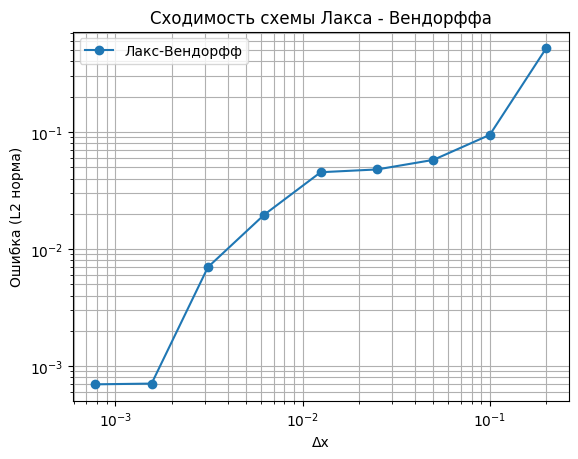

In [145]:
# Исследование сходимости
Ns = [5, 10, 20, 40, 80, 160, 320, 640, 1280]
errors = []
deltas = []

C = 0.9
for N in Ns:
    dx, error, *_ = solve_lax_wendroff(N, T, a, C)
    errors.append(error)
    deltas.append(dx)

# График сходимости
plt.figure()
plt.loglog(deltas, errors, 'o-', label='Лакс-Вендорфф')
plt.xlabel('Δx')
plt.ylabel('Ошибка (L2 норма)')
plt.grid(True, which='both')
plt.legend()
plt.title('Сходимость схемы Лакса - Вендорффа')
plt.show()

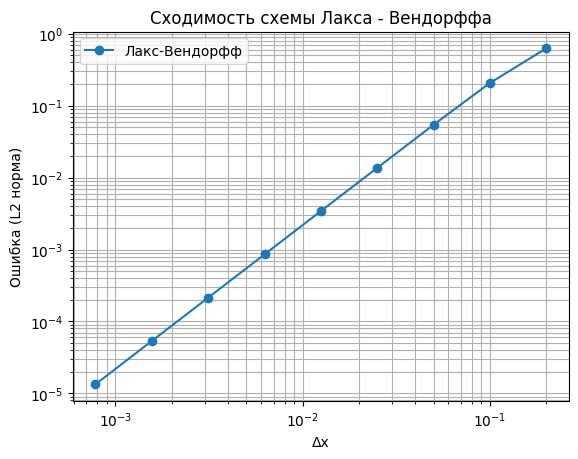

In [146]:
# Исследование сходимости
Ns = [5, 10, 20, 40, 80, 160, 320, 640, 1280]
errors = []
deltas = []

C = 0.5
for N in Ns:
    dx, error, *_ = solve_lax_wendroff(N, T, a, C)
    errors.append(error)
    deltas.append(dx)

# График сходимости
plt.figure()
plt.loglog(deltas, errors, 'o-', label='Лакс-Вендорфф')
plt.xlabel('Δx')
plt.ylabel('Ошибка (L2 норма)')
plt.grid(True, which='both')
plt.legend()
plt.title('Сходимость схемы Лакса - Вендорффа')
plt.show()

In [147]:
logs_dx = np.log(deltas)
logs_err = np.log(errors)
slope, intercept, *_ = linregress(logs_dx, logs_err)

print(f"Порядок аппроксимации ≈ {slope:.3f}")

Порядок аппроксимации ≈ 1.963


### **Вывод**

**Сравнение трёх численных схем**

В ходе работы были реализованы и исследованы три явные схемы для численного решения уравнения переноса:

| Схема               | Порядок аппроксимации        | Устойчивость                        | Особенности |
|---------------------|-------------------------------|-------------------------------------|-------------|
| **Уголок**          | 1-й порядок (по x и t)        | Устойчива при $C \leq 1$            | Простая, но неточная, даёт диффузию |
| **Прямоугольник**   | 2-й по x, 1-й по t            | Неустойчива при любом $C$           | Требует очень малого $C$, иначе расходится |
| **Лакс–Вендрофф**   | 2-й порядок (по x и t)        | Устойчива при $C \leq 1$            | Точная и устойчивая при $C \approx 0.5$ |



Выводы:

- Схема **«уголок»** — надёжная, но низкой точности. Подходит для грубых оценок.
- Схема **«прямоугольник»** — теоретически более точная, но практически неустойчивая для уравнения переноса.
- Схема **Лакса–Вендроффа** показала высокую точность и стабильность при $C \approx 0.5$ и подтвердила второй порядок сходимости

Таким образом, для уравнения переноса наиболее предпочтительной схемой является **Лакс–Вендрофф**, особенно при необходимости точного и устойчивого решения.
